Todo : 
- implement UCB1
- check if there are other algorithms
- find good experiments to compare algorithms
- reproduce experiment of https://arxiv.org/pdf/1506.03271.pdf (Section 4)

3 algorithms : Exp3, Exp3.P, Exp3-IX

# Exp-3 algorithms

ref :  https://jeremykun.com/2013/11/08/adversarial-bandits-and-the-exp3-algorithm/

https://arxiv.org/pdf/1506.03271.pdf

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
# need to define class arm (cf TD2)
class Arm():
    """ 
    Defines an arm with arbitrary finite sequence of reward
    """
    def __init__(self, rewards_sequence):
        self.rewards = rewards_sequence
    
    def sample(self, t):
        return self.rewards[t]

In [9]:
class bernoulliArm():
    def __init__(self, mean):
        self.mean = mean
    
    def sample(self, t):
        return np.random.binomial(p=self.mean, n=1)

In [10]:
class evolvingBernoulliArm():
    def __init__(self, means, switching_time):
        self.means = means
        self.switching_time = switching_time
    
    def sample(self, t):
        if t <= self.switching_time:
            return np.random.binomial(p=self.means[0], n=1)
        else:
            return np.random.binomial(p=self.means[1], n=1)

In [17]:
def exp3(MAB, T, gamma=0.05, Exp3P=False, alpha=0):
    """
    Exp3 algorithm as in Auer et al. (2001)
    MAB: list of arms from Arm class
    T: time horizon
    gamma: exploration parameter for Exp3
    """
    
    K = len(MAB) # number of arms
    
    # initialize weights
    W = np.ones(K) 
    if Exp3P:
        W *= np.exp(alpha*gamma/3*np.sqrt(T/K))
    
    # History of rewards and weights
    reward_hist = []
    weight_hist = np.zeros((T, K))

    
    for t in range(T):
        # Set probabilities of drawing each arm
        p = (1-gamma)*W/np.sum(W) + gamma/K
        
        # Draw arm index
        drawn_index = np.random.choice(a=K, p=p) 

        # Draw corresponding reward
        drawn_reward = MAB[drawn_index].sample(t) 
        
        # Compute estimated reward
        estimated_reward = drawn_reward/p[drawn_index] 
        
        # Update weights
        if Exp3P:
            W[drawn_index] *= np.exp(gamma*estimated_reward/K) 
        else:
            b =  alpha/(p[drawn_index]*np.sqrt(K*T))
            W[drawn_index] *= np.exp(gamma/(3*K)*(estimated_reward + b)) 
        
        # Save obtained reward and weights
        reward_hist.append(drawn_reward) 
        weight_hist[t, :] = W
        
    return reward_hist, weight_hist

In [18]:
def exp3_IX(MAB, T, eta, gamma):
    """
    Exp3-IX algorithm as in Explore no more (Neu)
    MAB: list of arms from Arm class
    T: the time horizon
    eta: learning rate
    gamma: implicit exploration parameter
    """
    
    K = len(MAB) # number of arms
    W = np.ones(K) # initialize weights
    
    # History of rewards and weights
    reward_hist = []
    weight_hist = np.zeros((T, K))
    
    for t in range(T):
        
        # Set probabilities of drawing each arm
        p = W/np.sum(W) 
        
        # Draw arm index
        drawn_index = np.random.choice(a=K, p=p)
        
        # Draw corresponding reward
        drawn_reward = MAB[drawn_index].sample(t) 
        
        # Compute estimated reward with implicit exploration
        estimated_reward = drawn_reward/(p[drawn_index] + gamma) 
        
        # Update weights
        W[drawn_index] *= np.exp(eta*estimated_reward) 
        
        # Save obtained reward and weights
        reward_hist.append(drawn_reward) 
        weight_hist[t, :] = W
        
    return reward_hist, weight_hist

In [19]:
# we define gaussian trajectories normalized to lie in [0, 1]

def gaussian_traj(T):
    gp = np.cumsum(np.random.normal(0, 2, T))

    # normalization (to have rewards in [0, 1]) :
    gp += np.abs(min(gp))
    gp /= max(gp)
    return(gp)

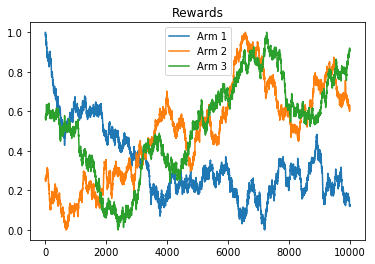

In [24]:
T = 10000

arm1 = Arm(gaussian_traj(T))
arm2 = Arm(gaussian_traj(T))
arm3 = Arm(gaussian_traj(T))

MAB = [arm1, arm2, arm3]

plt.plot(arm1.rewards)
plt.plot(arm2.rewards)
plt.plot(arm3.rewards)
plt.legend(['Arm 1', 'Arm 2', 'Arm 3'])
plt.title('Rewards')

In [31]:
rew, _ = exp3(MAB, T, gamma=0.05, Exp3P=False, alpha=0)
rew_P, _ = exp3(MAB, T, gamma=0.05, Exp3P=True, alpha=0.1)
rew_IX, _ = exp3_IX(MAB, T, eta=0.5, gamma=0.5)

arm1_cumsum = np.cumsum(arm1.rewards)
arm2_cumsum = np.cumsum(arm2.rewards)
arm3_cumsum = np.cumsum(arm3.rewards)
exp3_cumsum = np.cumsum(rew)
exp3_P_cumsum = np.cumsum(rew_P)
exp3_IX_cumsum = np.cumsum(rew_IX)

/Users/Schreuder/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in double_scalars
/Users/Schreuder/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/Schreuder/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


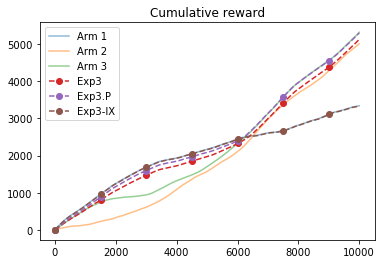

In [32]:
plt.plot(np.cumsum(arm1.rewards), alpha=0.5)
plt.plot(np.cumsum(arm2.rewards), alpha=0.5)
plt.plot(np.cumsum(arm3.rewards), alpha=0.5)
plt.plot(exp3_cumsum, '--o', markevery=1500)
plt.plot(exp3_P_cumsum, '--o', markevery=1500)
plt.plot(exp3_IX_cumsum, '--o', markevery=1500)

plt.legend(['Arm 1', 'Arm 2', 'Arm 3', 'Exp3', 'Exp3.P', 'Exp3-IX'])
plt.title("Cumulative reward")

In [18]:
best_action_rew = np.zeros(T)
for t in range(T):
    best_action_rew[t] = max(arm1_cumsum[t], arm2_cumsum[t], arm3_cumsum[t])

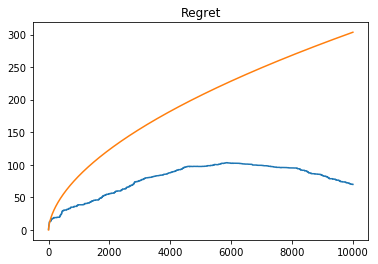

In [19]:
plt.plot(best_action_rew - exp3_P_cumsum)
plt.title('Regret')

lin = [np.sqrt(t*log(t)) for t in range(1, T)]
plt.plot(lin) 

In [20]:
# Exp3-IX expriment

Ref : https://arxiv.org/pdf/1506.03271.pdf (Section 4)

10-arm bandit problem where
all losses are independent draws of Bernoulli random variables. 

The mean rewards of arms 1 through 8 are 0.5

The mean reward of arm 9 is $0.5 + \delta$ for all rounds $t = 1, 2, . . . , T$. 

The mean rewards of
arm 10 are changing over time: for rounds $t \leq \frac{T}{2}$, the mean is $0.5 - \delta$, and $0.5 + 4\delta$ afterwards.

/!\ We consider rewards instead of losses (opposite to the article) 

In [21]:
T = 10000
delta = 0.1
MAB_IX = [bernoulliArm(0.5) for i in range(8)]
MAB_IX.append(bernoulliArm(0.5 + delta))
MAB_IX.append(evolvingBernoulliArm([0.5 - delta, 0.5 + 4*delta], T/2))

/Users/Schreuder/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
/Users/Schreuder/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/Schreuder/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/Users/Schreuder/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/Users/Schreuder/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in double_scalars
/Users/Schreuder/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/Schreuder/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


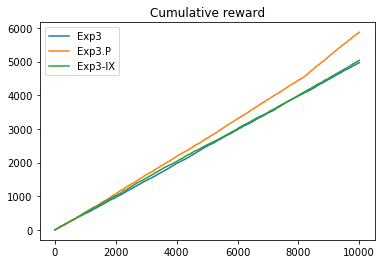

In [22]:
eta = 0.5
rew, _ = exp3(MAB_IX, T, eta)
rew_P, _ = exp3(MAB_IX, T, gamma=eta)
rew_IX, _ = exp3_IX(MAB_IX, T, eta, eta/2)

exp3_cumsum = np.cumsum(rew)
exp3_P_cumsum = np.cumsum(rew_P)
exp3_IX_cumsum = np.cumsum(rew_IX)

plt.plot(exp3_cumsum)
plt.plot(exp3_P_cumsum)
plt.plot(exp3_IX_cumsum)

plt.legend(['Exp3', 'Exp3.P', 'Exp3-IX'])
plt.title("Cumulative reward")